# Downstream adaption with MiniMol

This example shows how MiniMol can featurise small molecules that will then serve as an input to another model trained on a small downstream dataset from TDC ADMET. This allows to transfer the knowledge from the pre-trained MiniMol to another task. 

Before we start, let's make sure that the TDC package is installed in the environment. The package is quite large, and we assume that a user wouldn't necesserily need it in their work, that's why we don't include it in the dependencies.

In [1]:
# change cuXXX to the cuda driver version installed on your machine
%pip install torch-sparse torch-cluster torch-scatter -f https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
%pip install hydra-core
%pip install graphium==2.4.7
%pip install minimol
%pip install pytdc

## Step 1: Getting the data
Next, we will build a predictor for the `HIA Hou` dataset, one of the binary classification benchmarks from TDC ADMET group. HIA stands for human intestinal absorption (HIA), which is related to the ability to absorb a substance through the gastrointestinal system into the bloodstream of the human body.

We then split the data based on molecular scaffolds into training, validation and test sets. 

In [2]:
from tdc.benchmark_group import admet_group

DATASET_NAME = 'HIA_Hou'

admet = admet_group(path="admet-data/")

mols_test = admet.get(DATASET_NAME)['test']
mols_train, mols_val = admet.get_train_valid_split(benchmark=DATASET_NAME, split_type='scaffold', seed=42)

Found local copy...
generating training, validation splits...
generating training, validation splits...
100%|██████████| 461/461 [00:00<00:00, 3648.38it/s]


In [3]:
print(f"Dataset - {DATASET_NAME}\n")
print(f"Val split ({len(mols_val)} mols): \n{mols_val.head()}\n")
print(f"Test split ({len(mols_test)} mols): \n{mols_test.head()}\n")
print(f"Train split ({len(mols_train)} mols): \n{mols_train.head()}\n")

Dataset - HIA_Hou

Val split (58 mols): 
                 Drug_ID                                               Drug  Y
0         Atracurium.mol  COc1ccc(C[C@H]2c3cc(OC)c(OC)cc3CC[N@@+]2(C)CCC...  0
1  Succinylsulfathiazole          O=C(O)CCC(=O)Nc1ccc(S(=O)(=O)Nc2nccs2)cc1  0
2            Ticarcillin  CC1(C)S[C@H]2[C@@H](NC(=O)[C@@H](C(=O)O)c3ccsc...  0
3          Raffinose.mol  OC[C@@H]1O[C@@H](OC[C@@H]2O[C@@H](O[C@]3(CO)O[...  0
4          Triamcinolone  C[C@@]12C=CC(=O)C=C1CC[C@@H]1[C@H]3C[C@@H](O)[...  1

Test split (117 mols): 
                Drug_ID                                               Drug  Y
0         Trazodone.mol         O=c1n(CCCN2CCN(c3cccc(Cl)c3)CC2)nc2ccccn12  1
1          Lisuride.mol  CCN(CC)C(=O)N[C@H]1C=C2c3cccc4[nH]cc(c34)C[C@@...  1
2  Methylergonovine.mol  CC[C@H](CO)NC(=O)[C@H]1C=C2c3cccc4[nH]cc(c34)C...  1
3      Methysergide.mol  CC[C@H](CO)NC(=O)[C@H]1C=C2c3cccc4c3c(cn4C)C[C...  1
4       Moclobemide.mol                       O=C(NCCN1CCOCC1)c1ccc(Cl

## Step 2: Generating molecular fingerprints
Now that we have the splits, we will use MiniMol to embed all molecules. The embedding will be added as an extra column in the dataframe returned by TDC.

In [ ]:
from minimol import Minimol

featuriser = Minimol()

In [3]:
mols_val['Embedding'] = featuriser(list(mols_val['Drug']))
mols_test['Embedding'] = featuriser(list(mols_test['Drug']))
mols_train['Embedding'] = featuriser(list(mols_train['Drug']))

100%|██████████| 81/81 [00:05<00:00, 13.51it/s]


The model is small, so it took us 6.6 seconds to generate the embeddings for almost 600 molecules. Here is a preview after the new column has been added:

In [6]:
print(mols_train.head())

           Drug_ID                                               Drug  Y  \
0        Guanadrel                      N=C(N)NC[C@@H]1COC2(CCCCC2)O1  1   
1      Cefmetazole  CO[C@@]1(NC(=O)CSCC#N)C(=O)N2C(C(=O)O)=C(CSc3n...  0   
2   Zonisamide.mol                           NS(=O)(=O)Cc1noc2ccccc12  1   
3   Furosemide.mol            NS(=O)(=O)c1cc(Cl)cc(NCc2ccco2)c1C(=O)O  1   
4  Telmisartan.mol  CCCc1nc2c(n1Cc1ccc(-c3ccccc3C(=O)O)cc1)=C[C@H]...  1   

                                           Embedding  
0  [tensor(0.2477), tensor(0.1814), tensor(0.4020...  
1  [tensor(0.7070), tensor(0.4123), tensor(1.0127...  
2  [tensor(0.1878), tensor(-0.1408), tensor(0.891...  
3  [tensor(0.1206), tensor(0.3858), tensor(1.5851...  
4  [tensor(1.0168), tensor(1.1367), tensor(2.2483...  


## Step 3: Training a model
Now that the molecules are featurised leverging the representation MiniMol learned during its pre-training, we will set up a training and evaluation loop of a simple Multi-Layer Perceptron model using PyTorch.

Let's start by defining a new class for the dataset and then creating a separate dataloader for each split.

In [7]:
from torch.utils.data import DataLoader, Dataset
    
class AdmetDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples['Embedding'].tolist()
        self.targets = [float(target) for target in samples['Y'].tolist()]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = torch.tensor(self.samples[idx])
        target = torch.tensor(self.targets[idx])
        return sample, target

val_loader = DataLoader(AdmetDataset(mols_val), batch_size=128, shuffle=False)
test_loader = DataLoader(AdmetDataset(mols_test), batch_size=128, shuffle=False)
train_loader = DataLoader(AdmetDataset(mols_train), batch_size=32, shuffle=True)

Our model is a simple 3-layer perceptron with batch normalisation and dropout. We also add a residual connection that before the last layer concatates the the input features with the output from the second to last layer.

In [24]:
import torch.nn as nn
import torch.nn.functional as F


class TaskHead(nn.Module):
    def __init__(self):
        super(TaskHead, self).__init__()
        self.dense1 = nn.Linear(512, 512)
        self.dense2 = nn.Linear(512, 512)
        self.final_dense = nn.Linear(1024, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.10)

    def forward(self, x):
        original_x = x

        x = self.dense1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.dense2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = torch.cat((x, original_x), dim=1)
        x = self.final_dense(x)
        
        return x

Below we declare the basic hyperparamters, optimiser, loss function and learning rate scheduler. We build a model factory that allows us to instatiate a fresh copy of everything, which will become useful later.

In [22]:
import math
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

lr = 0.0003
epochs = 25
warmup = 5

loss_fn = nn.BCELoss()

def model_factory():
    model = TaskHead()
    optimiser = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
    
    def lr_fn(epoch):
        if epoch < warmup: return epoch / warmup
        else: return (1 + math.cos(math.pi * (epoch - warmup) / (epochs - warmup))) / 2

    lr_scheduler = LambdaLR(optimiser, lr_lambda=lr_fn)
    return model, optimiser, lr_scheduler

For evaluation we will use both AUROC and Average Precision metrics. The reported loss would be an average across all samples in the epoch.

In [25]:
import torch
from sklearn.metrics import roc_auc_score, average_precision_score

def evaluate(predictor, dataloader, loss_fn):
    predictor.eval()
    total_loss = 0
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            probs = torch.sigmoid(predictor(inputs).squeeze())
            loss = loss_fn(probs, targets)
            total_loss += loss.item()
            all_probs.extend(probs.tolist())
            all_targets.extend(targets.tolist())

    loss = total_loss / len(all_probs)
    
    return (
        loss,
        roc_auc_score(all_targets, all_probs),
        average_precision_score(all_targets, all_probs)
    )

Training is a rather standard boilerplate loop: 

In [26]:
def train_one_epoch(predictor, train_loader, val_loader, optimiser, lr_scheduler, loss_fn, epoch, eval=True):
    predictor.train()        
    train_loss = 0
    
    lr_scheduler.step(epoch)
    
    for inputs, targets in train_loader:
        optimiser.zero_grad()
        probs = torch.sigmoid(predictor(inputs).squeeze())
        loss = loss_fn(probs, targets)
        loss.backward()
        optimiser.step()
        train_loss += loss.item()

    train_loss /= (len(train_loader) * train_loader.batch_size)

    if eval:
        val_loss, auroc, avpr = evaluate(predictor, val_loader, loss_fn)
        print(
            f"## Epoch {epoch+1}\t"
            f"train_loss: {train_loss:.4f}\t"
            f"val_loss: {val_loss:.4f}\t"
            f"val_auroc: {auroc:.4f}\t"
            f"val_avpr: {avpr:.4f}"
        )
    return predictor

And now, let's see how good our model gets after training... 🚀

In [27]:
model, optimiser, lr_scheduler = model_factory()

val_loss, val_auroc, val_avpr = evaluate(model, val_loader, loss_fn)
print(
    f"## Epoch 0\t"
    f"train_loss: ------\t"
    f"val_loss: {val_loss:.4f}\t"
    f"val_auroc: {val_auroc:.4f}\t"
    f"val_avpr: {val_avpr:.4f}"
)

for epoch in range(epochs):
    model = train_one_epoch(model, train_loader, val_loader, optimiser, lr_scheduler, loss_fn, epoch)

test_loss, test_auroc, test_avpr = evaluate(model, test_loader, loss_fn)
print(
    f"test_loss: {test_loss:.4f}\n"
    f"test_auroc: {test_auroc:.4f}\n"
    f"test_avpr: {test_avpr:.4f}"
)

## Epoch 0	train_loss: ------	val_loss: 0.0132	val_auroc: 0.6979	val_avpr: 0.9076
## Epoch 1	train_loss: 0.0208	val_loss: 0.0131	val_auroc: 0.6479	val_avpr: 0.8884
## Epoch 2	train_loss: 0.0183	val_loss: 0.0102	val_auroc: 0.7792	val_avpr: 0.9384
## Epoch 3	train_loss: 0.0126	val_loss: 0.0069	val_auroc: 0.9208	val_avpr: 0.9792
## Epoch 4	train_loss: 0.0077	val_loss: 0.0052	val_auroc: 0.9542	val_avpr: 0.9893
## Epoch 5	train_loss: 0.0052	val_loss: 0.0042	val_auroc: 0.9667	val_avpr: 0.9927
## Epoch 6	train_loss: 0.0037	val_loss: 0.0038	val_auroc: 0.9708	val_avpr: 0.9938
## Epoch 7	train_loss: 0.0026	val_loss: 0.0037	val_auroc: 0.9562	val_avpr: 0.9899
## Epoch 8	train_loss: 0.0022	val_loss: 0.0034	val_auroc: 0.9604	val_avpr: 0.9909
## Epoch 9	train_loss: 0.0015	val_loss: 0.0037	val_auroc: 0.9542	val_avpr: 0.9887
## Epoch 10	train_loss: 0.0011	val_loss: 0.0029	val_auroc: 0.9771	val_avpr: 0.9951
## Epoch 11	train_loss: 0.0010	val_loss: 0.0027	val_auroc: 0.9833	val_avpr: 0.9965
## Epoch 12	tr

Running on a server-grade machine with 128 CPUs, the training took just 1.6s, reaching AUROC on the test set of 0.9951. As for the summer 2024, this is better than SoTA of 0.989. Pretty good!

## Step 4: Improvements

The result can be further improved. One problem is that the accuracy is quite sensitive to both the train-val splitting (reminder - we use scaffold splitting strategy) and the weight initialisation. Let's visualise the distribution of validation scores by training a few models:

In [29]:
def dataloader_factory(seed):
    mols_train, mols_val = admet.get_train_valid_split(benchmark=DATASET_NAME, split_type='scaffold', seed=seed)

    mols_val['Embedding'] = featuriser(list(mols_val['Drug']))
    mols_train['Embedding'] = featuriser(list(mols_train['Drug']))

    val_loader = DataLoader(AdmetDataset(mols_val), batch_size=128, shuffle=False)
    train_loader = DataLoader(AdmetDataset(mols_train), batch_size=32, shuffle=True)

    return val_loader, train_loader

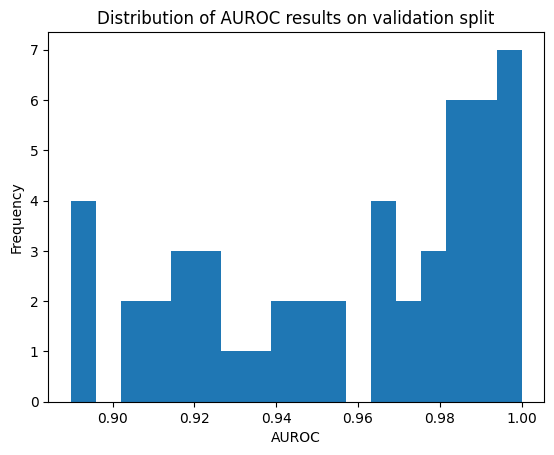

In [31]:
from contextlib import redirect_stdout, redirect_stderr# suppress some stdout for better readability
import matplotlib.pyplot as plt
from random import randint
import os

results = []
repeats = 50

for _ in range(repeats):
    with open(os.devnull, 'w') as fnull, redirect_stdout(fnull), redirect_stderr(fnull): # suppress output
        val_loader, train_loader = dataloader_factory(randint(0, 9999))
    model, optimiser, lr_scheduler = model_factory()
    for epoch in range(epochs):
        model = train_one_epoch(model, train_loader, val_loader, optimiser, lr_scheduler, loss_fn, epoch, eval=False)
    _, auroc, _ = evaluate(model, val_loader, loss_fn)
    results.append(auroc)

plt.hist(results, bins=18)
plt.xlabel('AUROC')
plt.ylabel('Frequency')
plt.title('Distribution of AUROC results on validation split')
plt.show()

As we can see, the scores can vary quite significantly, ranging from <0.9 to a perfect score.

To make the prediction more robust, we adapt two techniques:

- Ensembling models trained on different folds of train-val data. Since the training is so fast, fitting a few addtional models is not a big deal. The train-val splitting method is provided by TDC.

- Rather than choosing the model at the last epoch, we will use best validation loss to decide which one to choose.

We already implemented a `dataloader_factory()` method that creates a new training and validation dataloader for each fold. Now, we will also build a method for ensemble-based evaluation, that uses a list of models to caculate the average logits for the prediction.

In [32]:
import torch
from sklearn.metrics import roc_auc_score, average_precision_score

def evaluate_ensemble(predictors, dataloader, loss_fn):
    total_loss = 0
    all_probs = []
    all_targets = []

    with torch.no_grad():
        
        for inputs, targets in dataloader:
            model_outputs = [predictor(inputs).squeeze() for predictor in predictors]
            averaged_output = torch.sigmoid(torch.mean(torch.stack(model_outputs), dim=0))

            loss = loss_fn(averaged_output, targets)
            total_loss += loss.item()

            all_probs.extend(averaged_output.tolist())
            all_targets.extend(targets.tolist())

    loss = total_loss / len(all_probs)
    return loss, roc_auc_score(all_targets, all_probs), average_precision_score(all_targets, all_probs)

Finally, let's see how much better our model gets!

In [35]:
from copy import deepcopy

seeds = [1, 2, 3, 4, 5]

best_models = []

for fold_i, seed in enumerate(seeds):
    print(f"# Fold {fold_i +1} / {len(seeds)}")
    with open(os.devnull, 'w') as fnull, redirect_stdout(fnull), redirect_stderr(fnull): # suppress output
        val_loader, train_loader = dataloader_factory(seed)
    model, optimiser, lr_scheduler = model_factory()

    best_epoch = {"model": None, "result": None}
    for epoch in range(epochs):
        model = train_one_epoch(model, train_loader, val_loader, optimiser, lr_scheduler, loss_fn, epoch)
        val_loss, _, _ = evaluate(model, val_loader, loss_fn)

        if best_epoch['model'] is None:
            best_epoch['model'] = deepcopy(model)
            best_epoch['result'] = deepcopy(val_loss)
        else:
            best_epoch['model'] = best_epoch['model'] if best_epoch['result'] <= val_loss else deepcopy(model)
            best_epoch['result'] = best_epoch['result'] if best_epoch['result'] <= val_loss else deepcopy(val_loss)

    best_models.append(deepcopy(best_epoch['model']))

test_loss, test_auroc, test_avpr = evaluate_ensemble(best_models, test_loader, loss_fn)
print(
    f"test_loss: {test_loss:.4f}\n"
    f"test_auroc: {test_auroc:.4f}\n"
    f"test_avpr: {test_avpr:.4f}"
)

# Fold 1 / 5
## Epoch 1	train_loss: 0.0195	val_loss: 0.0112	val_auroc: 0.3277	val_avpr: 0.8480
## Epoch 2	train_loss: 0.0172	val_loss: 0.0091	val_auroc: 0.7815	val_avpr: 0.9616
## Epoch 3	train_loss: 0.0117	val_loss: 0.0059	val_auroc: 0.9160	val_avpr: 0.9873
## Epoch 4	train_loss: 0.0073	val_loss: 0.0041	val_auroc: 0.9524	val_avpr: 0.9931
## Epoch 5	train_loss: 0.0049	val_loss: 0.0033	val_auroc: 0.9636	val_avpr: 0.9951
## Epoch 6	train_loss: 0.0036	val_loss: 0.0033	val_auroc: 0.9580	val_avpr: 0.9943
## Epoch 7	train_loss: 0.0023	val_loss: 0.0028	val_auroc: 0.9720	val_avpr: 0.9964
## Epoch 8	train_loss: 0.0021	val_loss: 0.0026	val_auroc: 0.9776	val_avpr: 0.9971
## Epoch 9	train_loss: 0.0016	val_loss: 0.0027	val_auroc: 0.9720	val_avpr: 0.9963
## Epoch 10	train_loss: 0.0010	val_loss: 0.0025	val_auroc: 0.9748	val_avpr: 0.9967
## Epoch 11	train_loss: 0.0008	val_loss: 0.0022	val_auroc: 0.9776	val_avpr: 0.9971
## Epoch 12	train_loss: 0.0007	val_loss: 0.0022	val_auroc: 0.9804	val_avpr: 0.9974


In about 15s an ensemble was build reaching the performance of 0.9975 in AUROC on the test set. This is slightly better than the performance we achieved with a single model, but more importantly, the ensemble is not senstitive to which part of the data is used for validation, and is less sensitive to the intialisation because we intialise n models getting somewhere close to an average performance.

This score is better than the SoTA, showcasing how powerful MiniMol is in featurising molecules for downstream biological tasks.